In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.cluster import KMeans
from collections import Counter

In [3]:
train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [119]:
def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    return removed

In [28]:
def get_top_colors(img, n_colors, colorspace='HSV', ignore_white=True, white_v_thresh=200, white_s_thresh=30):
    """
    Get the top n_colors present in an image based on frequency (ignoring white).

    Args:
        img: Input BGR image.
        n_colors: Number of most frequent colors to return (characters + black lines).
        colorspace: 'HSV' or 'RGB' (default HSV).
        ignore_white: Whether to ignore white pixels.
        white_v_thresh: V threshold to consider pixel white (HSV only).
        white_s_thresh: S threshold to consider pixel white (HSV only).

    Returns:
        colors: np.ndarray of shape (<= n_colors, 3) with the most frequent colors.
    """
    # Convert color space
    if colorspace.upper() == 'HSV':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")

    # Flatten pixels
    pixels = img_c.reshape(-1, 3)
    
    # Optionally ignore white
    if ignore_white and colorspace.upper() == 'HSV':
        mask = ~((pixels[:,1] <= white_s_thresh) & (pixels[:,2] >= white_v_thresh))
        pixels = pixels[mask]

    # Convert to tuples for counting
    pixels_tuples = [tuple(p) for p in pixels]
    counts = Counter(pixels_tuples)
    
    # Take top n_colors
    top_colors = np.array([c for c, _ in counts.most_common(n_colors)], dtype=np.uint8)
    
    return top_colors

In [ ]:
def get_distinct_colors(img, n_colors, colorspace='HSV'):
    """
    Estimate distinct colors present in an image (e.g., captcha characters + lines).

    Args:
        img: Input BGR image.
        n_colors: Expected maximum number of colors (characters + 1 for lines).
        colorspace: 'HSV' or 'RGB'. HSV is default for better color grouping.

    Returns:
        colors: np.ndarray of shape (n_colors, 3) -> the cluster centers (uint8).
    """
    # Convert to desired color space
    if colorspace.upper() == 'HSV':
        converted = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")

    # Flatten and sample (for speed)
    pixels = converted.reshape(-1, 3).astype(np.float32)
    if len(pixels) > 5000:
        idx = np.random.choice(len(pixels), 5000, replace=False)
        pixels = pixels[idx]

    # K-Means clustering
    kmeans = KMeans(n_clusters=n_colors, n_init='auto', random_state=42)
    kmeans.fit(pixels)
    colors = np.uint8(kmeans.cluster_centers_)

    return colors

def show_colors(colors, label):
    swatch = np.zeros((50, 50 * len(colors), 3), dtype=np.uint8)
    for i, c in enumerate(colors):
        swatch[:, i*50:(i+1)*50] = c
    show_img(cv2.cvtColor(swatch, cv2.COLOR_HSV2BGR), title=label)

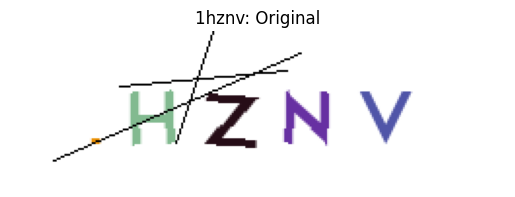

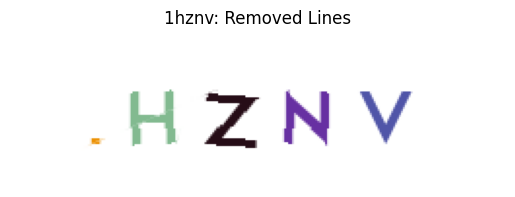

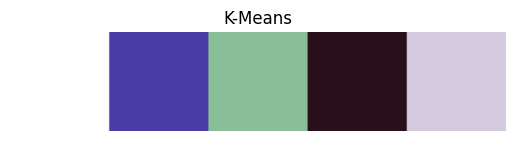

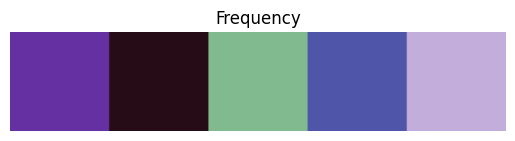

In [120]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img = remove_lines(img)
colors = get_top_colors(img, n_colors=len(label))
show_img(img, title=f"{label}: Removed Lines")

colors = get_distinct_colors(img, n_colors=len(label))
show_colors(colors, label="K-Means")

colors = get_top_colors(img, n_colors=len(label))
show_colors(colors, label="Frequency")

In [127]:
def mask_by_color(img, target_color, tol=30, colorspace='HSV'):
    """
    Create a binary mask isolating pixels close to a target color.

    Args:
        img: Input BGR image.
        target_color: Tuple/list of 3 values (HSV or RGB) to target.
        tol: Tolerance for each channel (+/- tol).
        colorspace: 'HSV' or 'RGB'. Default 'HSV'.

    Returns:
        mask: Binary mask (uint8) where 255 indicates pixels matching target color.
    """
    # Convert image if needed
    if colorspace.upper() == 'HSV':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")

    # Compute lower and upper bounds
    lower = np.array([max(0, int(c) - tol) for c in target_color], dtype=np.uint8)
    upper = np.array([min(255, int(c) + tol) for c in target_color], dtype=np.uint8)

    # Generate mask
    mask = cv2.inRange(img_c, lower, upper)
    
    # Optional: clean small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return mask

In [249]:
def show_masks(colors):
    for i, color in enumerate(colors):
        mask = mask_by_color(img, target_color=color)
        plt.figure()
        plt.title(f"{label}: Mask for color {i}")
        plt.axis('off')
        plt.imshow(mask, cmap='gray')
        plt.show()

def show_masked_images(img, colors, tol=20):
    """
    For each target color, create a mask and display the masked image.
    
    Args:
        img: Original BGR image
        colors: List/array of target colors (HSV or RGB)
        tol: Tolerance for color matching
    """
    for i, color in enumerate(colors):
        # Generate mask
        mask = mask_by_color(img, target_color=color, tol=tol)
        
        # Apply mask: keep color pixels, set rest to black
        masked_img = cv2.bitwise_and(img, img, mask=mask)
        
        # Show
        plt.figure()
        plt.title(f"{label}: Masked image for color {i}")
        plt.axis('off')
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.show()


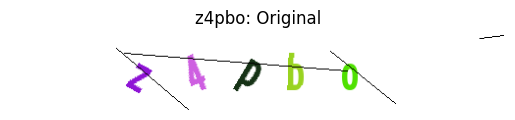

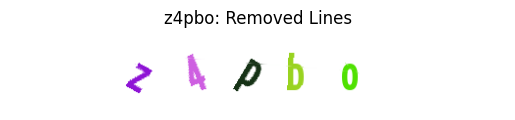

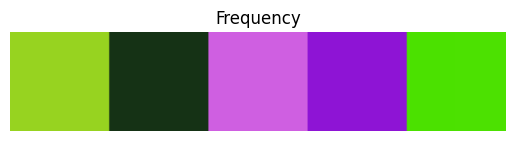

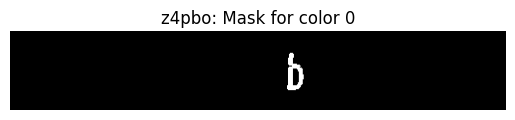

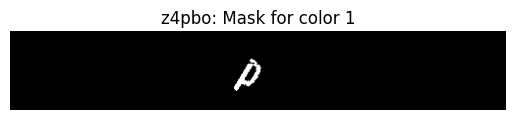

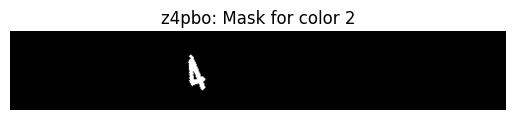

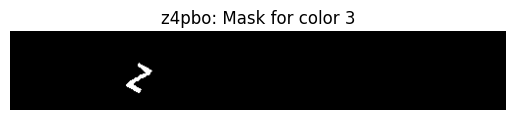

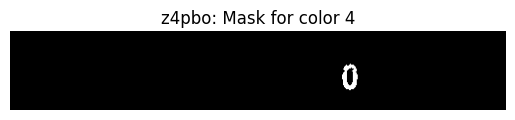

In [250]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img = remove_lines(img)
colors = get_top_colors(img, n_colors=len(label))
show_img(img, title=f"{label}: Removed Lines")

show_colors(colors, label="Frequency")

show_masks(colors)

In [ ]:
def enhance_contrast_saturation(img, alpha=1.5, beta=30, sat_factor=1.5):
    """
    Enhance contrast and saturation to make colors more distinct.
    
    Args:
        img: BGR input
        alpha: contrast multiplier
        beta: brightness shift
        sat_factor: HSV saturation multiplier
    """
    # Contrast & brightness (BGR)
    enhanced = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    
    # Increase saturation
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] = np.clip(hsv[:,:,1]*sat_factor, 0, 255)
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return enhanced

In [164]:
def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

def remove_lines_replace_white(img, black_thresh=60):
    """
    Remove black lines by replacing near-black pixels with white.

    Args:
        img: Input BGR image
        black_thresh: Any pixel with all channels below this is considered 'black'

    Returns:
        img_clean: Image with black lines replaced by white
    """
    img_clean = img.copy()

    # Mask for near-black pixels
    mask = np.all(img_clean <= black_thresh, axis=2)

    # Replace black pixels with white
    img_clean[mask] = [255, 255, 255]

    return img_clean

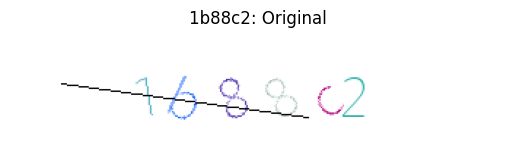

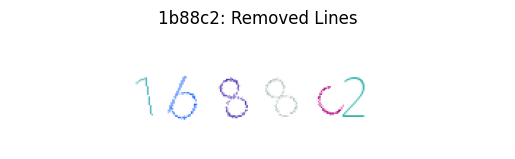

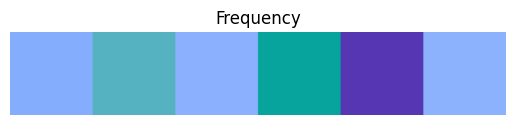

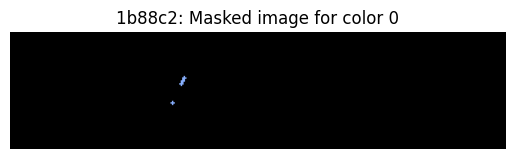

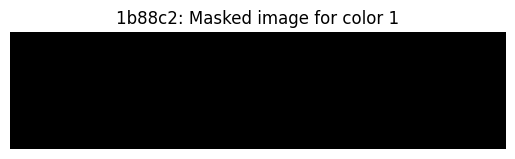

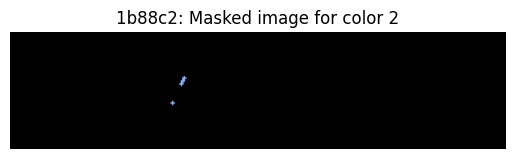

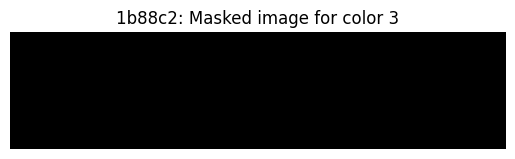

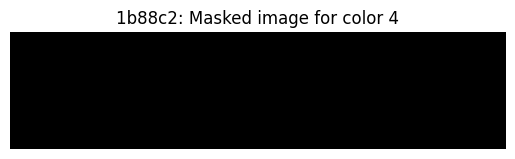

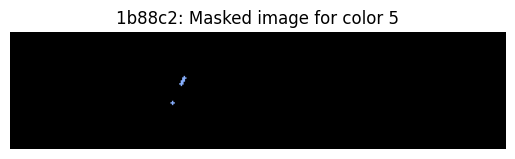

In [251]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img = remove_lines_replace_white(img)
show_img(img, title=f"{label}: Removed Lines")

colors = get_top_colors(img, n_colors=len(label))
show_colors(colors, label="Frequency")

show_masked_images(img, colors)

In [200]:
from scipy.spatial.distance import cdist
import numpy as np
import cv2

def iterative_color_propagation(img, top_colors, tol=30, max_iter=5, colorspace='HSV', neighborhood=1, white_thresh=220):
    """
    Iteratively propagate top colors to nearby pixels to fill gaps,
    while ignoring near-white background pixels.

    Args:
        img: BGR image (after line removal)
        top_colors: np.ndarray of shape (n_colors,3)
        tol: tolerance to consider pixel already matches a top color
        max_iter: maximum iterations
        colorspace: 'HSV' or 'Lab'
        neighborhood: pixel neighborhood radius for propagation
        white_thresh: pixel values above this are considered background and ignored

    Returns:
        img_filled: BGR image with pixels recolored to closest top color
    """
    img_c = img.copy()
    
    # Convert to chosen colorspace
    if colorspace.upper() == 'HSV':
        img_space = cv2.cvtColor(img_c, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'Lab':
        img_space = cv2.cvtColor(img_c, cv2.COLOR_BGR2Lab)
    else:
        raise ValueError("colorspace must be 'HSV' or 'Lab'")
    
    h, w = img_space.shape[:2]
    changed = True
    iteration = 0
    
    while changed and iteration < max_iter:
        changed = False
        iteration += 1
        img_copy = img_space.copy()
        
        for y in range(h):
            for x in range(w):
                pixel = img_space[y, x].astype(np.int32)
                
                # Skip near-white background pixels
                if np.all(img_c[y, x] >= white_thresh):
                    continue
                
                # Skip if pixel already matches a top color
                dists = np.linalg.norm(top_colors.astype(np.int32) - pixel, axis=1)
                if np.min(dists) <= tol:
                    continue
                
                # Examine neighborhood
                y1 = max(0, y - neighborhood)
                y2 = min(h, y + neighborhood + 1)
                x1 = max(0, x - neighborhood)
                x2 = min(w, x + neighborhood + 1)
                
                neighborhood_pixels = img_space[y1:y2, x1:x2].reshape(-1, 3)
                
                # Filter out near-white pixels in neighborhood
                mask_white = np.any(neighborhood_pixels >= white_thresh, axis=1)
                neighborhood_pixels = neighborhood_pixels[~mask_white]
                if len(neighborhood_pixels) == 0:
                    continue
                
                # Find closest top color to any pixel in neighborhood
                dists_neigh = cdist(neighborhood_pixels, top_colors, metric='euclidean')
                closest_idx = np.argmin(dists_neigh)
                closest_color = top_colors[closest_idx % len(top_colors)]
                
                # Assign pixel to closest top color
                img_copy[y, x] = closest_color
                changed = True
        
        img_space = img_copy.copy()
    
    # Convert back to BGR
    if colorspace.upper() == 'HSV':
        img_filled = cv2.cvtColor(img_space, cv2.COLOR_HSV2BGR)
    elif colorspace.upper() == 'Lab':
        img_filled = cv2.cvtColor(img_space, cv2.COLOR_Lab2BGR)
    
    return img_filled

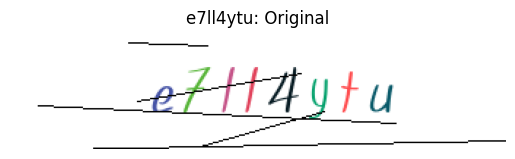

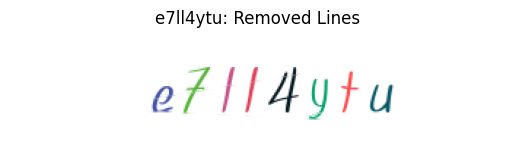

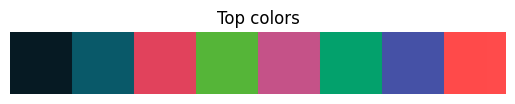

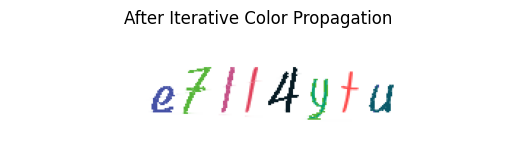

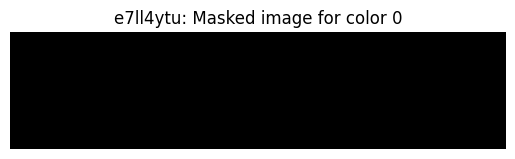

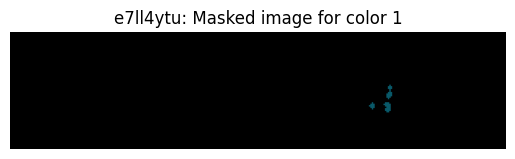

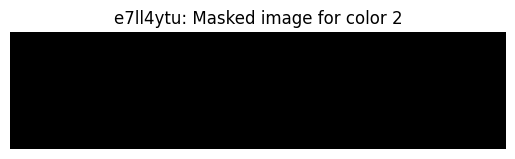

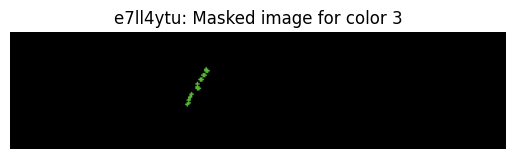

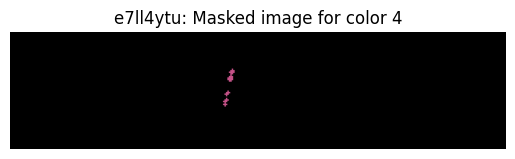

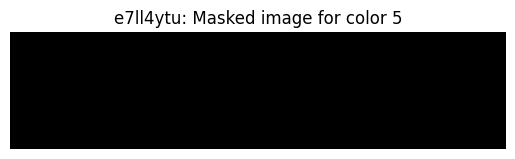

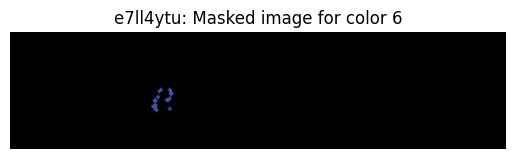

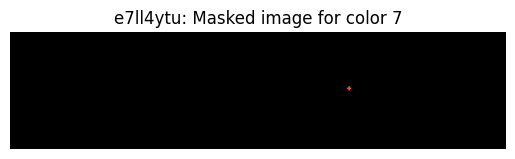

In [252]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Removed Lines")

top_colors = get_top_colors(img_clean, n_colors=len(label))
show_colors(top_colors, label="Top colors")

img_filled = iterative_color_propagation(img_clean, top_colors, tol=50, max_iter=30, neighborhood=5)
show_img(img_filled, title="After Iterative Color Propagation")


show_masked_images(img_filled, top_colors, tol=5)